# Preamble


The problems being addressed in this research are all part of ligand-based virtual screening (LBVS). LBVS is a method of predicting protein binding interactions of chemicals using machine-readable vector descriptions known as molecular fingerprints. LBVS uses predictive models like those from machine learning, which requires the input of a database of previously identified ligand-protein interactions. An algorithm is used that optimizes a relationship between input and output. This relationship maps the chemical vector descriptors (input) to another vector that represents the identity of the proteins the chemical is likely to bind (output). Another terminology used in the literature is multilabel learning - the function learns the many possible protein label sets for ligands.  

We use the ChEMBL database as the previously labelled dataset. We selected a group of 243 protein targets based on the size of their associated labelled chemical set, so that each protein has enough labelled instances to learn from, but not too much to make the problem unwieldy (some well-researched proteins have tens of thousands of ligands). Molecular fingerprints were generated with __RDKit__ python library. We used the de facto standard of morgan fingerprints, folded down to 256-dimension binary vectors. We use the python __scikit-learn__ for learning the mapping function and __scipy__ / __numpy__, __pandas__ for data manipulation and __matplotlib__ for plotting.



------


The full code is provided for reproducibility. However the authors are not professional software developers and so the code may not be optimized for readability. The authors welcome any questions, constructive criticism, and code re-use but please cite appropriately.



In [1]:
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import scipy
from scipy import sparse
from scipy import stats

import sklearn
from sklearn.metrics import pairwise_distances
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KernelDensity
from sklearn.metrics import label_ranking_loss

import pandas as pd

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

print('Pandas is:', pd.__version__)
print('Numpy is:', np.__version__)
print('Matplot is:', matplotlib.__version__)
print('Scipy is:', scipy.__version__)
print('Sklearn is:', sklearn.__version__)
print('RDKit is:', rdkit.__version__)

Pandas is: 0.24.2
Numpy is: 1.16.4
Matplot is: 3.1.0
Scipy is: 1.3.0
Sklearn is: 0.21.2
RDKit is: 2019.03.2


In [2]:
##
## Load dataset. Using the sklearn convention of x (featurized input vectors) and y (label vectors)
##

x = sparse.load_npz('../TheData/x_norm_sparse.npz')
y = sparse.load_npz('../TheData/y.npz')
x = np.array(x.todense(), dtype=bool)
y = np.array(y.todense())
allSmiles = pd.read_csv('../TheData/allSmiles.csv', header=None)
targetNames = pd.read_csv('../TheData/targetNames.csv', header=None)

In [3]:
def makeTimeSeries():
    val = []
    pos = 0.5
    ran = np.arange(0,1,0.01)
    for _ in ran:
        val.append(pos)
        pos += np.random.randn()/50
        
    return ran, val
np.random.seed()
ran, val = makeTimeSeries()

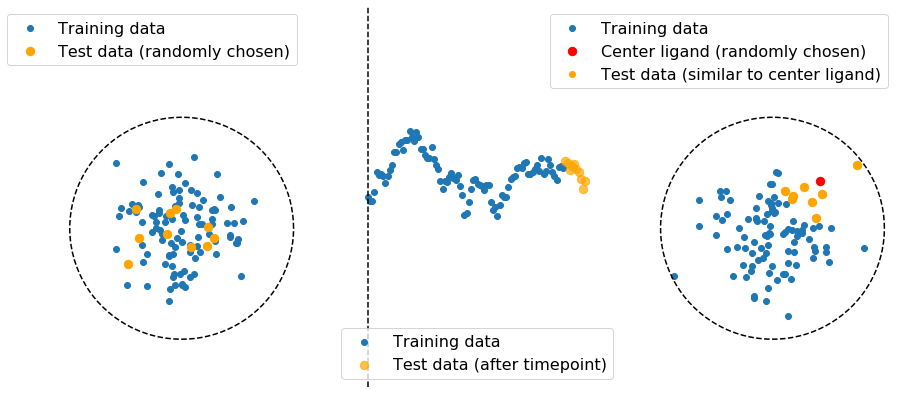

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,7))
np.random.seed(7)

#first panel:
ax[0].axis('off')

sample = np.random.randn(100,2)
ax[0].scatter(sample[:,0], sample[:,1], label='Training data')
ax[0].scatter(np.random.randn(10), np.random.randn(10), label='Test data (randomly chosen)', c='orange', s=70)
an = np.linspace(0, 2 * np.pi, 100)
ax[0].plot(3.5 * np.cos(an), 3.5 * np.sin(an), linestyle='--', c='k')
ax[0].legend(fontsize=16)
ax[0].set_ylim(-5,7)

#second panel:
ax[1].axvline(0, linestyle='--', c='k')
ax[1].axis('off')
ax[1].scatter(ran[:-10], val[:-10], label='Training data')
ax[1].scatter(ran[-10:], val[-10:], alpha=0.7, s=70, c='orange', label='Test data (after timepoint)')
ax[1].set_ylim(0,1)

ax[1].legend(fontsize=16, loc='lower center')

#third panel
ax[2].axis('off')
sample = np.random.randn(100,2)
ax[2].scatter(sample[:,0], sample[:,1], label='Training data')
sample2 = np.random.randn(10,2)/5+2
#ax[2].scatter(sample2[:,0], sample2[:,1], label='Test data (randomly chosen)', c='orange')

for point in sample:
    if np.linalg.norm(point-np.array([1.5,1.5]))<1.25:
        p = point
        ax[2].scatter(p[0], p[1], c='orange', s=70)

plt.scatter(1.5, 1.5, c='r', label='Center ligand (randomly chosen)', s=70)
        
ax[2].scatter(p[0], p[1], c='orange', label='Test data (similar to center ligand)')
                      
an = np.linspace(0, 2 * np.pi, 100)
ax[2].plot(3.5 * np.cos(an), 3.5 * np.sin(an), linestyle='--', c='k')

ax[2].legend(fontsize=16, loc='upper right')
ax[2].set_ylim(-5,7)

fig.savefig('figure_1a_blockbootstrap.png',facecolor='white', edgecolor='none')


# Highly correlated data

Virtual screening is designed to predict new protein labels for incoming ligands based on their fingerprint. One of the biggest issues in methods development in virtual screening is the problem of memorization: the active ligands that we know about are not drawn at random from the larger population of possible active ligands. Most of the time one ligand is discovered, and med chemists perform structure activity relationship studies, creating a whole series of highly similar chemicals. This can also be stated as saying "_the data is not i.i.d._" - independent and identically distributed. Many such analogues are so highly similar, or 'correlated', that really they should always be grouped together as if they were a single, independent structure. In time series analysis this is called 'block averaging', whereby adjacent points in time are averaged until the total dataset variance stabilizes[1]. Chemical series aren't linear like time series, however. For now we just recognise that highly correlated points are grouped together to maintain independence.

While the concept of a scaffold is slightly fuzzy and depends on whether you ask a chemist or a pharmacologist, we may be able to find a definition or metric for structural analogues that satisfies both chemical intuition as well as the underlying shape of the data. 

To this end: __we seek a metric to separate highly correlated data points from independent data points.__

Not all distance metrics are equal. As seen below, one of the common standards, Rogers-Tanimoto, has scores that occupy a small range compared to the minimum (0) and maximum (1) possible values. Similarly, Minkowski seems to bunch up at higher values. Compared to these, __Dice similarity__ nicely fills up the whole range. Thus it may be simpler to use Dice to separate same-scaffold versus different-scaffold pairs, and we use it from here on.

[1]Flyvbjerg, H., & Petersen, H. G. (1989). Error estimates on averages of correlated data. The Journal of Chemical Physics, 91(1), 461-466.


Target is: Orexin receptor 2


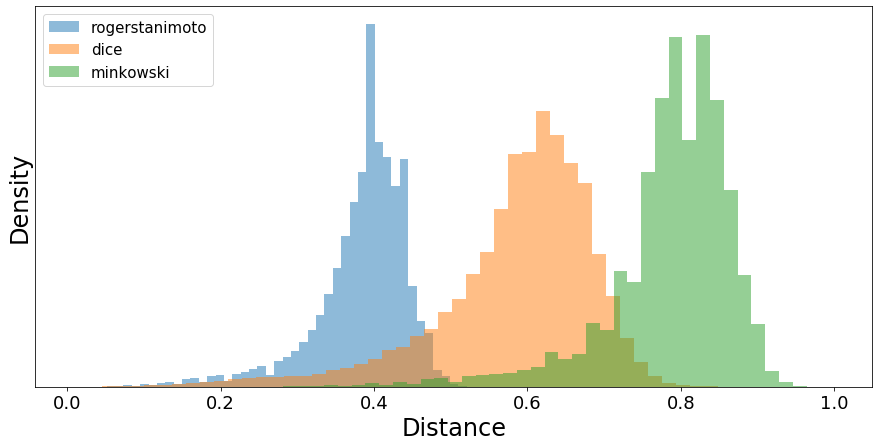

In [5]:
def plotHisto(x_instances, metric, ax, label):
    distance_matrix = pairwise_distances(x_instances, metric=metric)
    if metric=='minkowski':
        distance_matrix *= 1/distance_matrix.max() #normalize 0->1
    ax.hist(distance_matrix[distance_matrix>0], bins=50, alpha=0.5, label=label)
    return ax

targ = np.random.choice(y.shape[1]) #choose target at random
print('Target is:', targetNames[0].iloc[targ])
x_instances = x[y[:,targ]==1] #these are the x vectors with this target label

#plot:
ax = plt.axes()
ax.figure.set_size_inches(15,7)
for metric in ['rogerstanimoto', 'dice', 'minkowski']:
    plotHisto(x_instances, metric, ax, label=metric)

ax.set_yticks([])
ax.tick_params(axis='both', which='major', labelsize=18)

ax.set_xlabel('Distance', fontsize=24)
ax.set_ylabel('Density', fontsize=24)
ax.legend(fontsize=15)

ax.figure.savefig('supp_distances.png',facecolor='white', edgecolor='none')

## Separating correlated from independent


Whichever way you define analogues, at the very least we can all agree that if you take a sample of pairwise similarities from the chemicals within a given target label, it must contain both 1) analogue pairs and 2) independent pairs. Consistent with this, viewing the histograms of pairwise similarities shows two normally-distributed components. 

__We thus model the distribution of pairwise distances by fitting a two-component Gaussian Mixture__ to the histogram. Using n=2 in sklearn will fit two normal distributions, with the intuition that one of the Gaussians will be fit to the analogue pair distances, and the other will be fit to the independent pair distances. 

Below shows an example of what this looks like for a single target. This takes all the distances of each pair of chemicals for a single target label, then fit two gaussians to that distribution. You can see a clear bi-modal shape. 

Target is: Protein kinase C theta


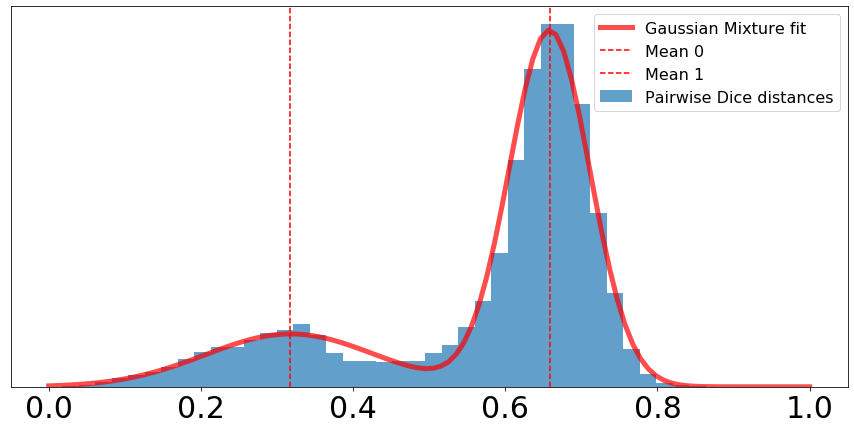

In [6]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(2, covariance_type='full', random_state=0)

#targ = np.random.choice(y.shape[1]) #choose target at random
targ = 182 ##This is a good demonstration target.
print('Target is:', targetNames[0].iloc[targ])
x_instances = x[y[:,targ]==1] #these are the x vectors with this target label
distance_matrix = pairwise_distances(x_instances, metric='dice')
distances = distance_matrix[distance_matrix>0].reshape(-1,1)
gm.fit(distances)

gm_x = np.linspace(0, 1, 100)
gm_y = np.exp(gm.score_samples(gm_x.reshape(-1,1)))
ax = plt.axes()
ax.figure.set_size_inches(15,7)

ax.hist(distances,bins=40, density=True, label='Pairwise Dice distances', alpha=0.7)
ax.plot(gm_x, gm_y, c='red', linewidth=5, label='Gaussian Mixture fit', alpha=0.7)
[ax.axvline(j, c='red', linestyle='--', label='Mean '+str(count)) for count, j in enumerate(gm.means_)]
ax.legend(prop={'size': 16})

ax.tick_params(labelsize=30)
ax.set_yticks([])

ax.figure.savefig('figure_1c_gmm.png',facecolor='white', edgecolor='none')


##  Repeating for many targets to get some statistics

We can repeat this for multiple targets to get a fairer idea of where the analogue and independent gaussian distance centres are located. Then, we can pick a point in-between the two to use as a separating plane, i.e. a cutoff mark that separates analogue pair distances from independent pair distances

In [7]:
##Fitting gaussian mixtures to ALL targets


same_scaffold_means = list()
different_scaffold_means = list()

gm = GaussianMixture(2, covariance_type='full', random_state=0)

for targ in range(243): #sample some targets for fitting.
    print(targ, end='\r')
    x_instances = x[y[:,targ]==1]
    distance_matrix = pairwise_distances(x_instances, metric='dice')
    distances = distance_matrix[distance_matrix>0].reshape(-1,1)
    gm.fit(distances)

    same_scaffold_means.append(min(gm.means_))
    different_scaffold_means.append(max(gm.means_))
    

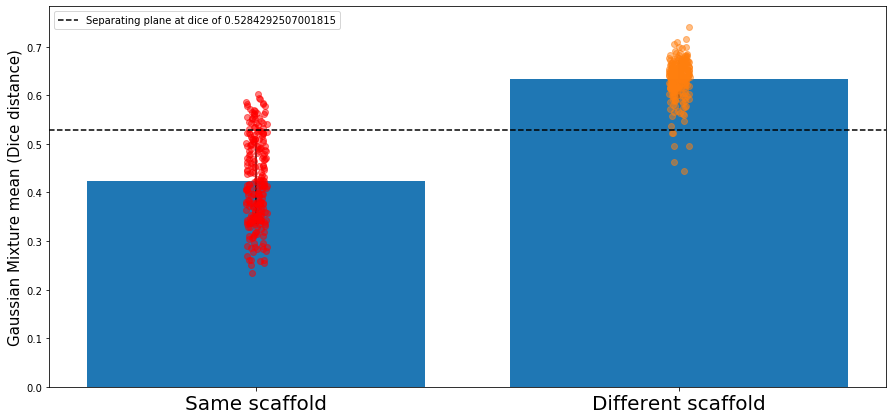

In [8]:
ax = plt.axes()
ax.figure.set_size_inches(15,7)

ax.bar([0,1], 
       [np.mean(same_scaffold_means), 
        np.mean(different_scaffold_means)],
        yerr=[np.std(same_scaffold_means),np.std(different_scaffold_means)])

ax.set_xticks([0,1])
ax.set_xticklabels(['Same scaffold', 'Different scaffold'], fontsize=20)
ax.set_ylabel('Gaussian Mixture mean (Dice distance)', fontsize=15)

sam = np.array(same_scaffold_means)
diff = np.array(different_scaffold_means)

sep_plane = np.mean(np.mean(np.concatenate([diff,sam], axis=1), axis=1))
ax.axhline(sep_plane, 
           linestyle='--', 
           color='k', 
           label='Separating plane at dice of '+str(sep_plane))

ax.scatter(np.zeros(243)+np.random.uniform(-0.025, 0.025, 243), 
           same_scaffold_means, 
           color='red', 
           zorder=2, 
           alpha=0.5)
ax.scatter(np.ones(243)+np.random.uniform(-0.025, 0.025, 243), 
           different_scaffold_means, 
           zorder=2, 
           alpha=0.5)

ax.legend()

In [9]:
print('The Dice distance in between same-scaffold and different-scaffold inferred from 20 Gaussian mixture fits is: \n%s'
    %str((np.mean(different_scaffold_means) -np.mean(same_scaffold_means))/2 + np.mean(same_scaffold_means)))

The Dice distance in between same-scaffold and different-scaffold inferred from 20 Gaussian mixture fits is: 
0.5284292507001817


# Determining separating plane values

While there is a bit of overlap across the proposed separating plane, and certainly some noise across different targets, there is a clear separation of the two distributions. The separating plane as plotted above is the mean of the halfway point between each pair of gaussian centres in the 243 targets sampled.

To get an estimate of all the positions of the mean that are compatible with the data we use bootstrapping to get a 95% CI, taking 10,000 samples with replacement. Then the 95% CI is bounded by the 250th and 9750th of the ranked sample means: 

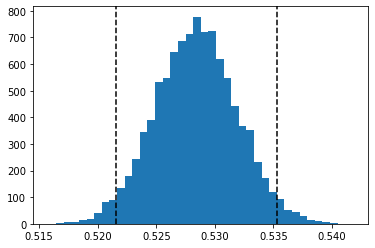

In [10]:
observations = list()
for j,k in zip(sam.reshape(1,-1)[0], diff.reshape(1,-1)[0]):
    sep = (k - j)/2 + j
    observations.append(sep)

means = list()
for _ in range(10000):
    samples = np.random.choice(observations, len(observations), replace=True)
    means.append(np.mean(samples))
    
means=np.array(means)
sorted_means = means[np.argsort(means)]

plt.hist(means, bins=40)
plt.axvline(sorted_means[250], c='k', linestyle='--')
plt.axvline(sorted_means[9750], c='k', linestyle='--')

In [11]:
ninety_five_ci = [sorted_means[250], sorted_means[9750]]

print('Ninety five percent CI: ', ninety_five_ci)

Ninety five percent CI:  [0.5215811211678315, 0.5352990735132935]


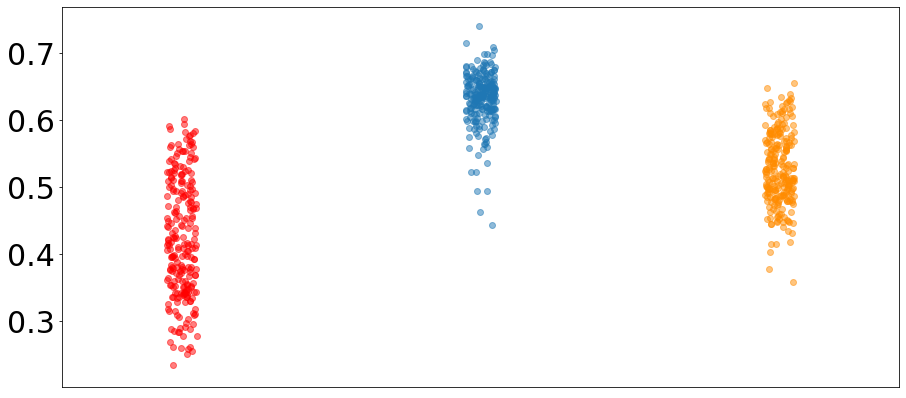

In [12]:
ax = plt.axes()
ax.figure.set_size_inches(15,7)

ax.set_xticks([])

sam = np.array(same_scaffold_means)
diff = np.array(different_scaffold_means)


ax.scatter(np.zeros(243)+np.random.uniform(-0.025, 0.025, 243), 
           same_scaffold_means, 
           color='red', 
           zorder=2, 
           alpha=0.5)
ax.scatter(np.ones(243)/2+np.random.uniform(-0.025, 0.025, 243), 
           different_scaffold_means, 
           zorder=2, 
           alpha=0.5)

ax.scatter(np.ones(243)+np.random.uniform(-0.025, 0.025, 243), 
           observations, 
           zorder=2,
           color='darkorange',
           alpha=0.5)

ax.tick_params(labelsize=30)
plt.xlim(-0.2,1.2)

ax.figure.savefig('figure_1d_mean_cutoff.png',facecolor='white', edgecolor='none')



## How well does the cutoff work?
We used a cutoff of Dice distance d = 0.525 which is in the 95% CI. How does this proposed cutoff behave? The below shows that it conforms to expections. The below grabs some proposed analogue pairs first, using the defition of dice<0.525, and visualizes them side-by-side. The target labels will be written underneath. Each two molecules are a pair with d<0.525:

In [13]:

def makePairs(comparison, targ):
    smi = allSmiles[0].iloc[y[:,targ]==1]
    distance_matrix = pairwise_distances(x[y[:,targ]==1], metric='dice')
    a,b = np.where(comparison(distance_matrix, 0.525))
    selection = np.random.choice(a.shape[0])
    m1,m2 = Chem.MolFromSmiles(smi.iloc[a[selection]]), Chem.MolFromSmiles(smi.iloc[b[selection]])
    return m1,m2


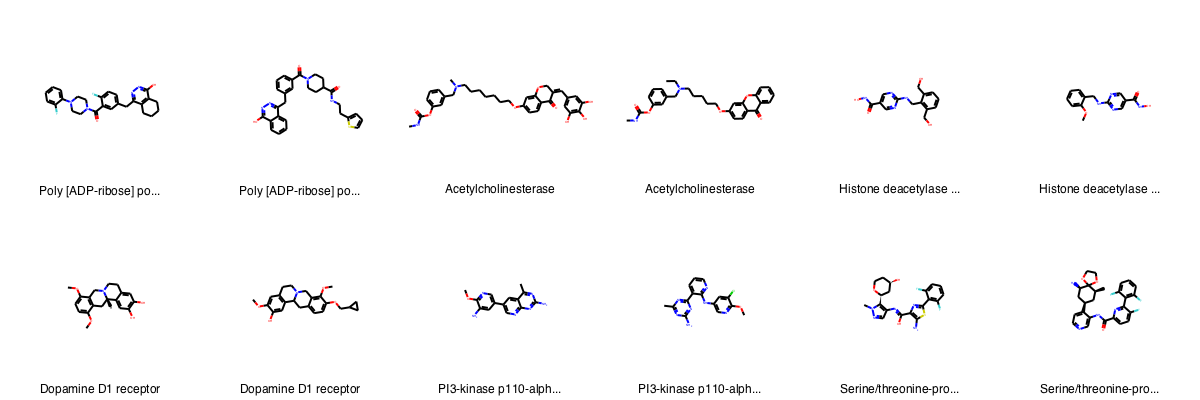

In [14]:
molPairs = list()
names = list()

for targ in np.random.choice(y.shape[1],6):
    a,b = makePairs(np.less, targ)
    molPairs.append(a)
    molPairs.append(b)
    if len(targetNames[0].iloc[targ]) > 20:
        name = targetNames[0].iloc[targ][:20]+'...'
    else:
        name = targetNames[0].iloc[targ]
    names.append(name)
    names.append(name)
    
##Note that while some R groups change, each pair has common scaffolds
Draw.MolsToGridImage(molPairs, molsPerRow=6, legends=names)

All seem to have a substantial maximum common substructure. Compare the similarity of the above pairs to some proposed independent pairs, again chosen at random and from within a target label but with dice>0.525. It's much more difficult to find a large maximum common substructure here. So most would agree that the choice of 0.525 is leading to pairs that are well defined in terms of having the same, or different, scaffold.

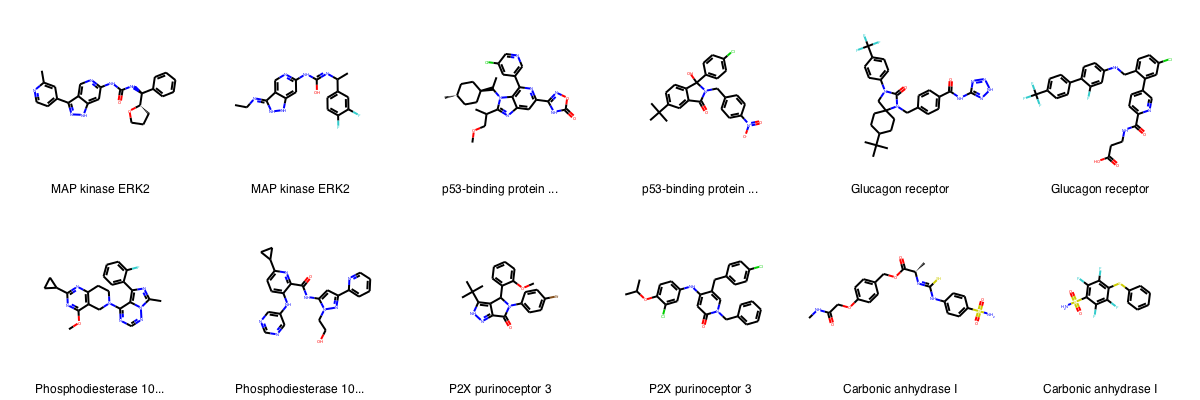

In [15]:
molPairs = list()
names = list()

for targ in np.random.choice(y.shape[1],6):
    a,b = makePairs(np.greater, targ)
    molPairs.append(a)
    molPairs.append(b)
    if len(targetNames[0].iloc[targ]) > 20:
        name = targetNames[0].iloc[targ][:20]+'...'
    else:
        name = targetNames[0].iloc[targ]
    names.append(name)
    names.append(name)
    
Draw.MolsToGridImage(molPairs, molsPerRow=6, legends=names)

#  

# Scoring virtual screening using analogue-removal

Now that we have a simple rubric for detecting highly correlated data, we can remove the influence of memorization bias in virtual screening. Now, to determine the performance of virtual screening methods we need a fair scoring metric.

For time series analysis, highly correlated data points can be grouped by blocking average, i.e. averaging adjacent points until the variance stabilises. In machine learning contexts, often financial data time series are analyzed using 'backtesting', whereby data at any given time are predicted only using data from the preceding times. This ensures no future information is included in the model, which would allow it to 'cheat'. 

For molecular screening data, there isn't a simple equivalent. New scaffolds tend to be added in groups when they are discovered, allowing time-split cross validation or backtesting. But __old scaffolds keep reappearing in subsequent time blocks__, and this happens to differing degrees for different targets. Additionally, due to an already sparse data set, __some time-blocks are empty__. This obscures clear analysis. 

Another method of scoring is clustered cross validation. Clustering has many pitfalls. K-means assumes normally-distributed clusters and prior knowledge of the number of clusters. Density based clustering tends to leave points out as noise. And __all methods are susceptible to accidentally leaking__ an analogue pair member at the edge of a cluster into an adjacent cluster.

__The best way to prevent this is to explicitly remove data-points that are highly correlated (determined by dice distance) from each and every training/test split.__

This is essentially a blocked experimental design. We use a block bootstrapping approach to repeatedly select ligands, masking the highly correlated duplicates within the cutoff, then train on the remaining ligands. The test set is the set of masked ligands + some randomly selected negatives. This takes much more computation for the scoring metric to converge than a simple 10-fold cross validation would cost, but it is mitigated by:
* parallelization
* weighting the random selection of ligands to be masked, encouraging even sampling across all independent blocks 
* an early stopping criterion.

Despite higher computation costs, this process is justified if it results in a rigorous measure for methods development. 


Here is the code, which non-python readers may skip:


In [16]:
from joblib import Parallel, delayed
from sklearn.preprocessing import normalize
import copy


class VirtualScreeningBootstrapper():
    def __init__(self, x, y, clf, numNegs=0.2):
        self.x = x
        self.y = y
        self.clf = clf

        self.positive_indices = None
        self.negative_indices = None
        self.dist = None
        self.targetIndex = None
        self.fraction = None
        self.numNegs = numNegs

    def setTarget(self, target_index):
        self.targetIndex = target_index
        self.positive_indices = np.where(self.y[:,self.targetIndex]==1)[0]
        self.negative_indices = np.where(self.y[:,self.targetIndex]==0)[0]
        self.weights = np.ones(len(self.positive_indices))

        print(len(self.positive_indices), len(np.where(self.y[:,self.targetIndex]==1)[0]))
        self.dist = pairwise_distances(np.array(self.x[self.positive_indices], dtype=bool), metric='dice')

    def maskNN(self):
        self.weights=normalize([self.weights], norm='l1')[0]
        selection = np.random.choice(self.positive_indices, p=self.weights) #take a random true positive ligand
        ligand_index = np.where(self.positive_indices==selection)[0][0]

        knn = np.where(self.dist[ligand_index]<self.fraction)[0] #these are the nearest neighbours
        add=0.01
        while len(knn)<10: #ensure we have at least 10 positive ligands.
            knn = np.where(self.dist[ligand_index]<(self.fraction+add))[0]
            add+=0.01

        distances = self.dist[ligand_index][knn]
        self.weights[knn] *= (distances+0.01) #change the weights

        mask = np.ones(len(self.x), dtype=bool) #create a mask
        mask[self.positive_indices[knn]]=False #set only the neighbors to False
        return mask

    def maskNegs(self, mask):
        neg_selection = np.random.choice(self.negative_indices, int(self.numNegs*len(self.negative_indices)))
        mask[neg_selection]=False
        return mask

    def evaluateFold(self, clf, mask):
        probs = clf.predict_proba(self.x[~mask])[:,1] #get probability of test ligands being positive
        ranking_loss = label_ranking_loss(self.y[~mask][:,self.targetIndex].reshape(1,-1), probs.reshape(1,-1))
        return ranking_loss

    def bootstrap_par(self, mask):
        clf = copy.copy(self.clf)
        clf.fit(self.x[mask], self.y[mask][:,self.targetIndex])
        ranking_loss = self.evaluateFold(clf, mask)
        return ranking_loss

    def makeMask(self):
        mask = self.maskNN() #generate a mask for a random block of positives
        mask = self.maskNegs(mask) #mask some negatives too
        return mask

    def bootStrap(self, target_index, fraction, repeats, tolerance=2.5, numJobs=1):
        self.setTarget(target_index)
        self.fraction = fraction

        ranking_losses = list()

        for rep in range(repeats):
            print(rep, end='\r')
            if numJobs>1:
                masks = [self.makeMask() for _ in range(numJobs)] #make the masks first to ensure even sampling by the weights.
                                                                ##otherwise you might get odd results from joblib setting weights
                                                                ##all at the same time
                rlosses = Parallel(n_jobs=numJobs, backend='threading')(delayed(self.bootstrap_par)(mask) for mask in masks)
                for rloss in rlosses:
                    ranking_losses.append(rloss)
            else:
                mask = self.makeMask()
                ranking_loss = self.bootstrap_par(mask)
                ranking_losses.append(ranking_loss)

            if len(ranking_losses)>53:
                medians = [np.median(ranking_losses[:-i]) for i in np.arange(1,51)]
                diffs = [np.abs(medians[-1]- median) for median in medians[:-1]]
                diffs_percent = [(d / medians[-1])*100 for d in diffs]
                if max(diffs_percent)<tolerance:
                    break
        return ranking_losses
    

#  

We test the virtual screening bootstrapper to see how it performs below. Keep in mind the problem setting here, to use the information retrieval term, is binary relevance - fitting a single target label against all other labels. There are more sophisticated techniques coming from the 'extreme multilabel learning' literature.  If the label is present in ChEMBL, the interaction is treated as a positive. If the label is _not_ present in ChEMBL, that interaction is treated explicitly as a negative.


We use a BernoulliNB to measure performance. While there are arguments to be made for using random forests or logistic regression, in this work we are focused on the label matrix, which is classifier-agnostic. 


We use the _'ranking loss'_ metric. 
In contrast to precision and recall, ranking loss does not care for yes/no predictions. __A good ranking loss score of 0 has the highest probabilities assigned to known positives__. A bad score of 0.5 has random rankings of positives and negatives. This is in line with the realities of a drug discovery project - usually we are happy to test as many predicted ligands as we can afford, or until they cease being effective, so we just want to go down the ranked list. Additionally, it allows true positives that haven't been discovered yet to be ranked highly without being punished for reducing precision.

The cell below just calculates the ranking loss until the median converges, or until 120x4 repeats have been done. This is just because the laptop used for this has 4 cores.

In [20]:
vsbs = VirtualScreeningBootstrapper(x, y, BernoulliNB())
targ = np.random.choice(y.shape[1])
print('Target is: ', targetNames.iloc[targ])
ranking_loss = vsbs.bootStrap(targ, 0.1, 150, tolerance=2.5, numJobs=4) #this was done on a laptop. Best to go up to many cores if possible.


Target is:  0    Vanilloid receptor
Name: 237, dtype: object
2312 2312


Inspecting the data using a kernel density estimate (a continuous histogram), we see that it is not quite normally-distributed (some targets are worse than others). Most randomly selected ligands (and their associated scaffold neighbors) cluster around the median value, but some scaffolds are more difficult to predict and get much worse ranking loss. 

The plot below shows the density of ranking losses of all the bootstrapping trials for this label, along with the mean and median. Because of the non-normal shape, to get a fairer idea of the performance, we will use the median. 

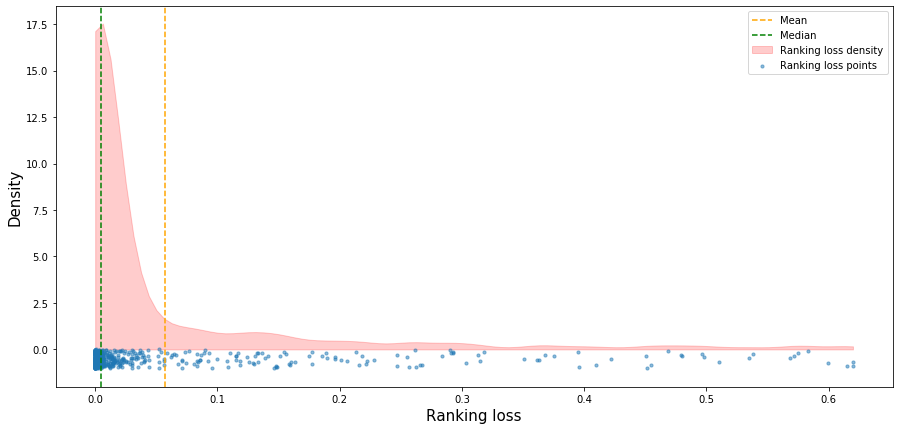

In [21]:
from sklearn.neighbors import KernelDensity
def plotKDE(data, ax, label, c='red', bw=0.025):
    bw=bw
    kde_in = KernelDensity(bandwidth=bw, kernel='gaussian')
    kde_in.fit(np.array(data).reshape(-1,1))

    X_plot = np.linspace(0, max(data), 100)[:, np.newaxis]
    logprob = kde_in.score_samples(X_plot.reshape(-1,1))

    ax.fill_between(X_plot[:,0], np.exp(logprob), alpha=0.2, color=c, label=label)
    
    return ax

ax = plt.axes()
ax.figure.set_size_inches(15,7)
ax = plotKDE(ranking_loss, ax, 'Ranking loss density', 'red', bw=0.015)

ax.set_xlabel('Ranking loss', fontsize=15)
ax.set_ylabel('Density', fontsize=15)
ax.scatter(ranking_loss, np.random.uniform(-1,0, len(ranking_loss)), s=10, alpha=0.5, label='Ranking loss points')
ax.axvline(np.mean(ranking_loss), linestyle='--',color='orange', label='Mean')
ax.axvline(np.median(ranking_loss), linestyle='--', color='green', label='Median')
ax.legend()


We can now look at convergence of the ranking loss metric over the bootstrapping repeats. How many trials does it take to converge? Many more than 10-fold CV unfortunately. But the value converges in the limit of repeats. We use early-stopping to approximate this - once the cumulative median has flattened out (as judged by the maximum absolute % difference to any of the cumulative medians over the last 40 trials), we stop. 


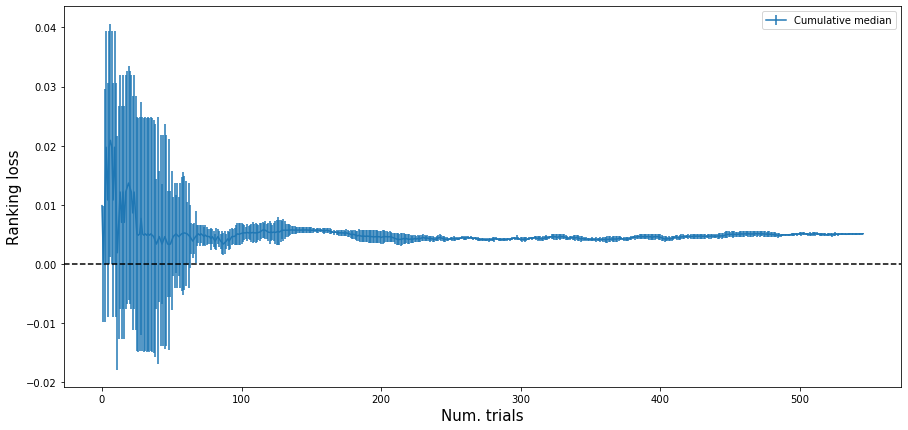

In [22]:
def getYerr(rloss):
    yerr = list()
    for count in range(2,len(rloss)):
        if count<3:
            yerr.append(0)
        else:
            go_back=min(count, 40)
            medians = [np.median(rloss[:count][:-i]) for i in np.arange(1,go_back)]
            diffs = [np.abs(medians[-1]- median) for median in medians[:-1]]
            yerr.append(max(diffs))
    return yerr

def plotRlossMedian(rloss, ax, label):
    ax.errorbar(np.arange(len(rloss)-2), 
                [ np.median(rloss[:i]) for i in range(2, len(rloss))],
                yerr = getYerr(rloss), label=label)
    return ax
    

ax = plt.axes()
ax.figure.set_size_inches(15,7)
ax.axhline(0, linestyle='--', color='k')
ax.set_ylabel('Ranking loss', fontsize=15)
ax.set_xlabel('Num. trials', fontsize=15)


plotRlossMedian(ranking_loss, ax, label='Cumulative median')
ax.legend()

# Conclusion Pt. 1

So now we have a good definition of scaffold and non-scaffold pairs that is motivated by the structure of the underlying data, and also conforms to a chemists expectations. 

There is also now a robust method of block bootstrapping that explicitly removes the same-scaffold examples in every case. This prevents highly correlated data points being present across the test and train sets, also known as test/train leakage. 

This method converges to a median value for the ranking loss, allowing easy and robust comparisons of classifier performance under different conditions.


In the following two parts, this technique is used to demonstrate improvements on the existing label set provided by ChEMBL.